<a href="https://colab.research.google.com/github/GipsyOmega/Generating-ECG-Samples-using-DCGAN/blob/main/Generating_ECG_samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
#import wfdb
import tarfile
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
#from keras.preprocessing.sequence import pad_sequences
import math
import warnings
import os
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy import signal
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import h5py
path_to_file = "/content/drive/MyDrive/exams_part0.hdf5"
f = h5py.File(path_to_file, 'r')
# Get ids
traces_ids = np.array(f['exam_id'])
x = f['tracings']
ECGs = np.asarray(x)

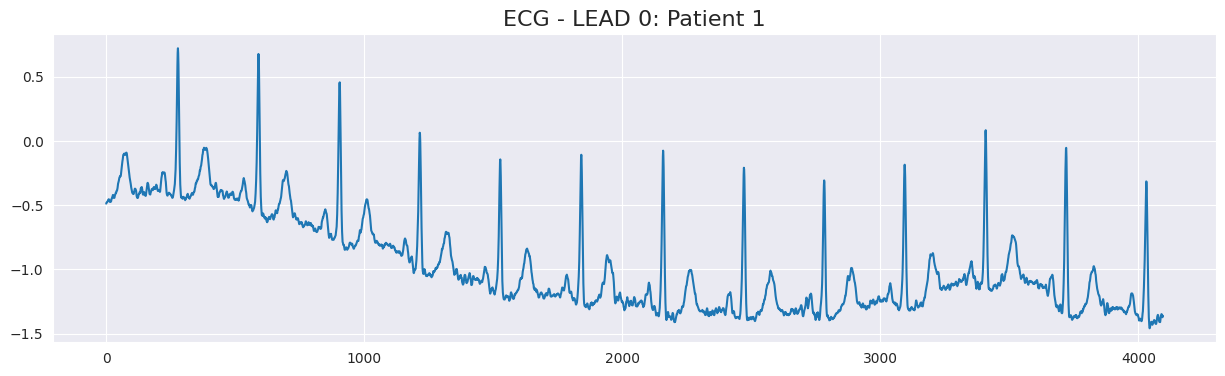

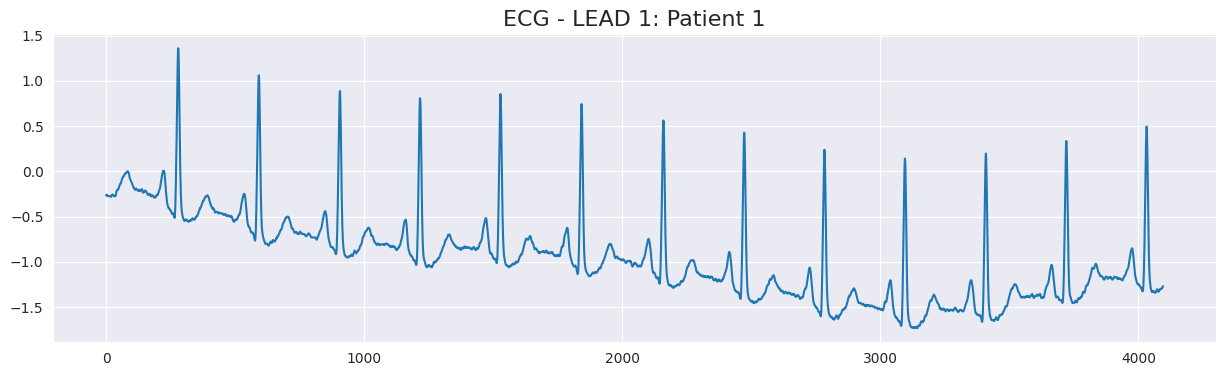

In [4]:
import seaborn as sns
sns.set_style("darkgrid")
for i in range(2):
  plt.figure(figsize = (15,4))
  plt.title("ECG - LEAD {}: Patient 1".format(i), fontsize = 16)
  plt.yticks()
  plt.plot(x[0,:,i])
  print()
  plt.show()

In [5]:
# generate n real samples with class labels
def generate_real_samples(ecgsignal,n):
    """Randomly pick n real ECG samples from the dataset and return it together with an array of n ones """
    # generate inputs in [-0.5, 0.5]
    X = ecgsignal[np.random.choice(ecgsignal.shape[0],n)]
    # generate class labels
    y = tf.ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    """Generate random numbers used as input to the generator """
    # generate points in the latent space
    x_in = np.random.randn(latent_dim*n).reshape(n,latent_dim)
    # reshape into a batch of inputs for the network
    return np.expand_dims(x_in,1)
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(latent_dim,generator,n):
    """Use the generator to generate fake ECGs"""
    # generate points in latent space
    x_input = generate_latent_points(latent_dim,n)
    # predict outputs
    X = generator(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

def compare_real_and_gen_ecg(generated_ecg):
    """Plot real and generated ECGs side by side"""
    plt.figure(figsize=(24,4))
    plt.subplot(1,2,1)
    plt.title("Generated (fake) ECG - Lead I", fontsize=16)
    plt.plot(generated_ecg[0,:,0])
    plt.subplot(1,2,2)
    plt.title("Real ECG - Lead I", fontsize=16)
    rand_idx = np.random.choice(np.arange(len(ECGs)))
    plt.plot(ECGs[rand_idx,:,0])
    plt.show()

In [6]:
def _inception_module(
    input_tensor,
    stride=1,
    activation="linear",
    use_bottleneck=True,
    kernel_size=40,
    bottleneck_size=32,
    nb_filters=32,
):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(
            filters=bottleneck_size,
            kernel_size=1,
            padding="same",
            activation=activation,
            use_bias=False,
        )(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2**i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(
            tf.keras.layers.Conv1D(
                filters=nb_filters,
                kernel_size=kernel_size_s[i],
                strides=stride,
                padding="same",
                activation=activation,
                use_bias=False)(input_inception))

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding="same")(
        input_tensor
    )

    conv_6 = tf.keras.layers.Conv1D(
        filters=nb_filters,
        kernel_size=1,
        padding="same",
        activation=activation,
        use_bias=False,
    )(max_pool_1)

    conv_list.append(conv_6)

    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation="relu")(x)
    return x


def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(
        filters=int(out_tensor.shape[-1]), kernel_size=1, padding="same", use_bias=False
    )(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation("relu")(x)
    return x


def discriminator(input_shape = (4096,12), nb_classes=1, depth: int = 1,use_residual: bool = True)-> tf.keras.models.Model:
    """
    Model proposed by HI Fawas et al 2019 "Finding AlexNet for Time Series Classification - InceptionTime"
    """
    input_layer = tf.keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    output_layer = tf.keras.layers.Dense(units=nb_classes, activation="sigmoid")(
        gap_layer
    )

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.MeanSquaredError()],
    )

    return model


In [7]:
desc = discriminator()
print("Discriminator architecture:")
print(desc.summary())

Discriminator architecture:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4096, 32)     384         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 4096, 12)     0           ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4096, 32)     40960       ['conv1d[0][0]']                 
                                                                  

In [8]:
path_disc = "/content/discriminator_weights_round1.h5"
desc.load_weights(path_disc)

In [9]:
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(12*4096, use_bias=False, input_shape=(1,12)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((4096,12)))
    assert model.output_shape == (None, 4096, 12)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv1DTranspose(128, 5, strides= 1, padding='same', use_bias=False))
    assert model.output_shape == (None, 4096, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(64,  5, strides= 1, padding='same', use_bias=False))
    assert model.output_shape == (None, 4096, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(12, 5, strides=1, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 4096, 12)
    return model

In [10]:
gen = generator()
print("Generator architecture:")
print(gen.summary())

Generator architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1, 49152)          589824    
                                                                 
 batch_normalization_1 (Batc  (None, 1, 49152)         196608    
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 49152)          0         
                                                                 
 reshape (Reshape)           (None, 4096, 12)          0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4096, 128)        7680      
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (N

In [11]:
path_gen = "/content/generator_weights_round1.h5"
gen.load_weights(path_gen)

Before training:


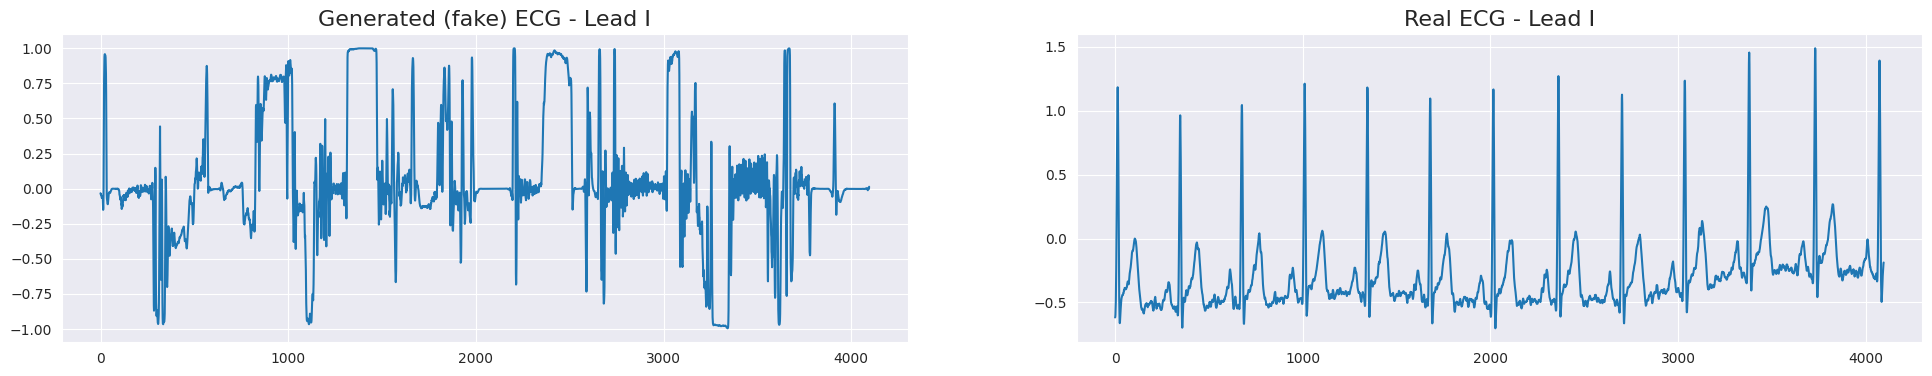

-------------------
epoch 0
Generator AUROC: 0.0
Generator loss: 0.9237668
Descriminator AUROC: 0.5546875
Descriminator loss: 0.543355
-------------------
epoch 1


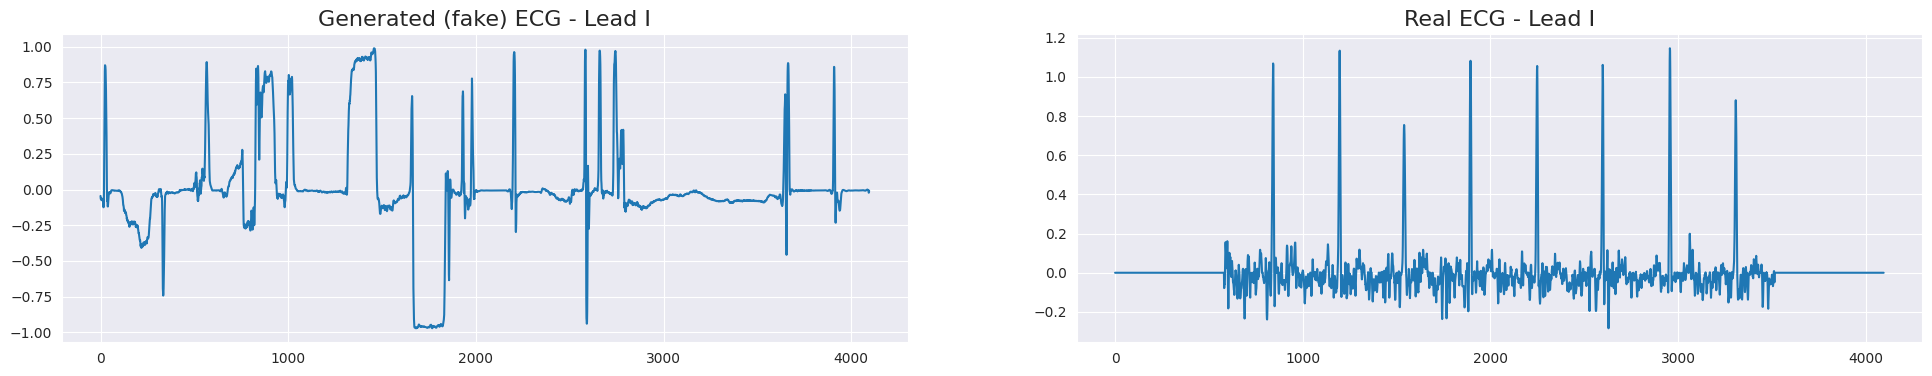

Generator AUROC: 0.0
Generator loss: 0.90721345
Descriminator AUROC: 0.48046875
Descriminator loss: 0.5430027
-------------------
epoch 2
Generator AUROC: 0.0
Generator loss: 0.91929334
Descriminator AUROC: 0.62890625
Descriminator loss: 0.54207236
-------------------
epoch 3
Generator AUROC: 0.0
Generator loss: 0.93200994
Descriminator AUROC: 0.533203125
Descriminator loss: 0.53703004
-------------------
epoch 4
Generator AUROC: 0.0
Generator loss: 0.9353157
Descriminator AUROC: 0.359375
Descriminator loss: 0.53440994
-------------------
epoch 5
Generator AUROC: 0.0
Generator loss: 0.9401513
Descriminator AUROC: 0.703125
Descriminator loss: 0.53544354
-------------------
epoch 6


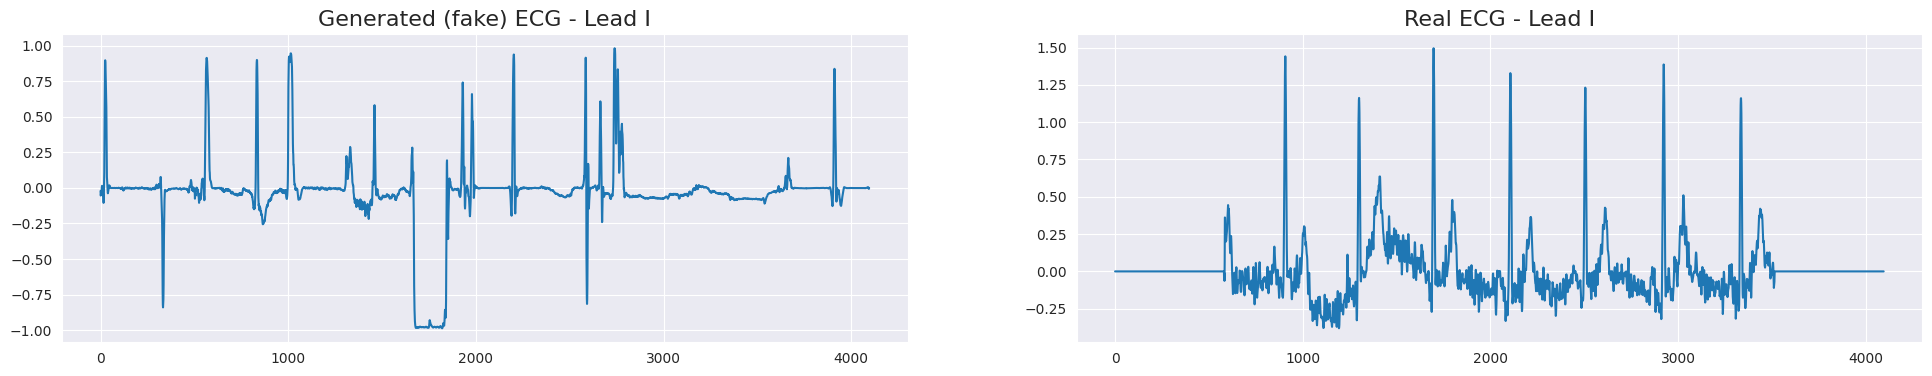

Generator AUROC: 0.0
Generator loss: 0.9422768
Descriminator AUROC: 0.53125
Descriminator loss: 0.528555
-------------------
epoch 7
Generator AUROC: 0.0
Generator loss: 0.9492793
Descriminator AUROC: 0.34375
Descriminator loss: 0.5269261
-------------------
epoch 8
Generator AUROC: 0.0
Generator loss: 0.95546037
Descriminator AUROC: 0.42578125
Descriminator loss: 0.52554065
-------------------
epoch 9
Generator AUROC: 0.0
Generator loss: 0.9609696
Descriminator AUROC: 0.75390625
Descriminator loss: 0.52529854
-------------------
epoch 10
Generator AUROC: 0.0
Generator loss: 0.95973897
Descriminator AUROC: 0.44140625
Descriminator loss: 0.5207035
-------------------
epoch 11


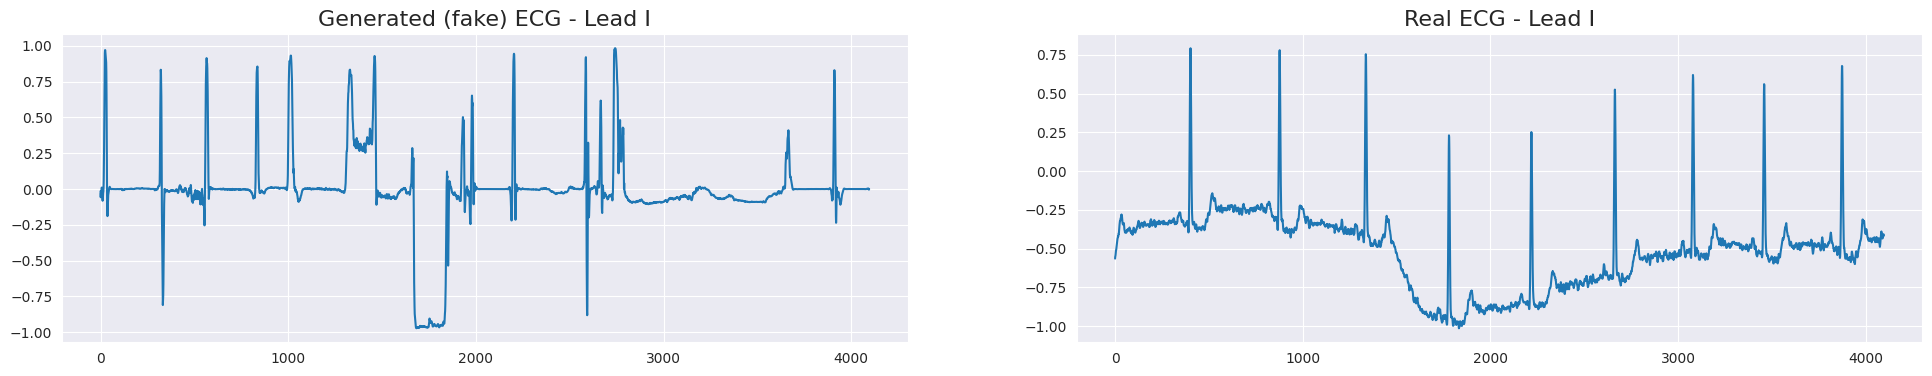

Generator AUROC: 0.0
Generator loss: 0.9646521
Descriminator AUROC: 0.44921875
Descriminator loss: 0.52153224
-------------------
epoch 12
Generator AUROC: 0.0
Generator loss: 0.9617334
Descriminator AUROC: 0.5
Descriminator loss: 0.5247824
-------------------
epoch 13
Generator AUROC: 0.0
Generator loss: 0.96578616
Descriminator AUROC: 0.72265625
Descriminator loss: 0.5205733
-------------------
epoch 14
Generator AUROC: 0.0
Generator loss: 0.963896
Descriminator AUROC: 0.5859375
Descriminator loss: 0.5228874
-------------------
epoch 15
Generator AUROC: 0.0
Generator loss: 0.9641889
Descriminator AUROC: 0.48046875
Descriminator loss: 0.5233739
-------------------
epoch 16


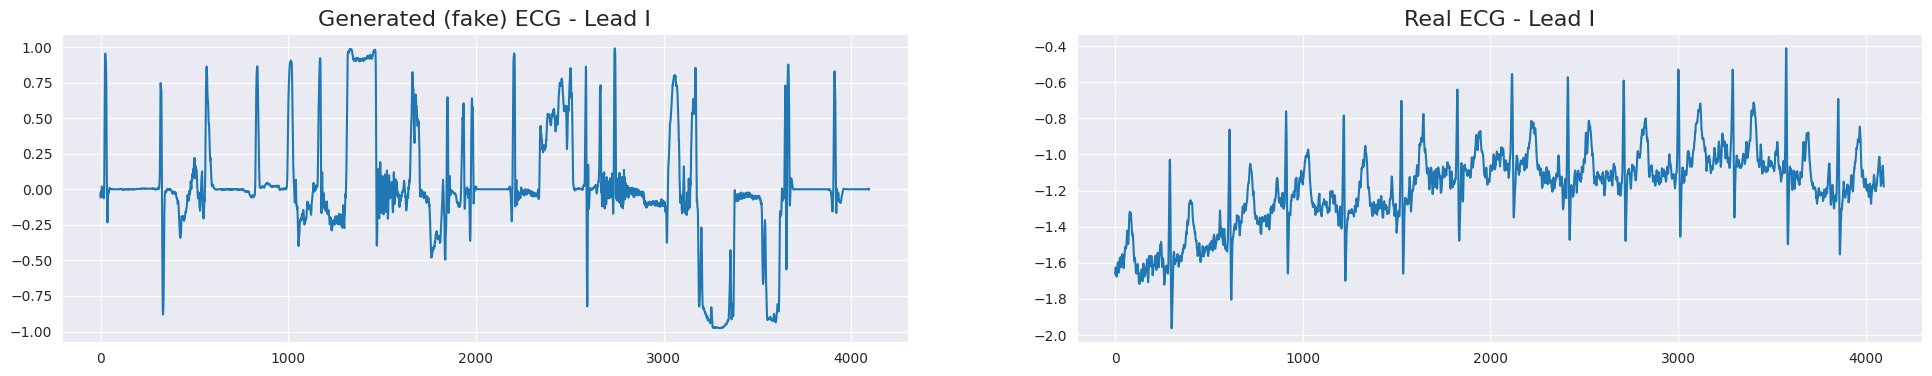

Generator AUROC: 0.0
Generator loss: 0.9637217
Descriminator AUROC: 0.51171875
Descriminator loss: 0.51992404
-------------------
epoch 17
Generator AUROC: 0.0
Generator loss: 0.96259755
Descriminator AUROC: 0.37890625
Descriminator loss: 0.52075505
-------------------
epoch 18
Generator AUROC: 0.0
Generator loss: 0.9652447
Descriminator AUROC: 0.36328125
Descriminator loss: 0.5182031
-------------------
epoch 19
Generator AUROC: 0.0
Generator loss: 0.97055644
Descriminator AUROC: 0.41015625
Descriminator loss: 0.5163446
-------------------
epoch 20
Generator AUROC: 0.0
Generator loss: 0.96845585
Descriminator AUROC: 0.37890625
Descriminator loss: 0.51909804
-------------------
epoch 21


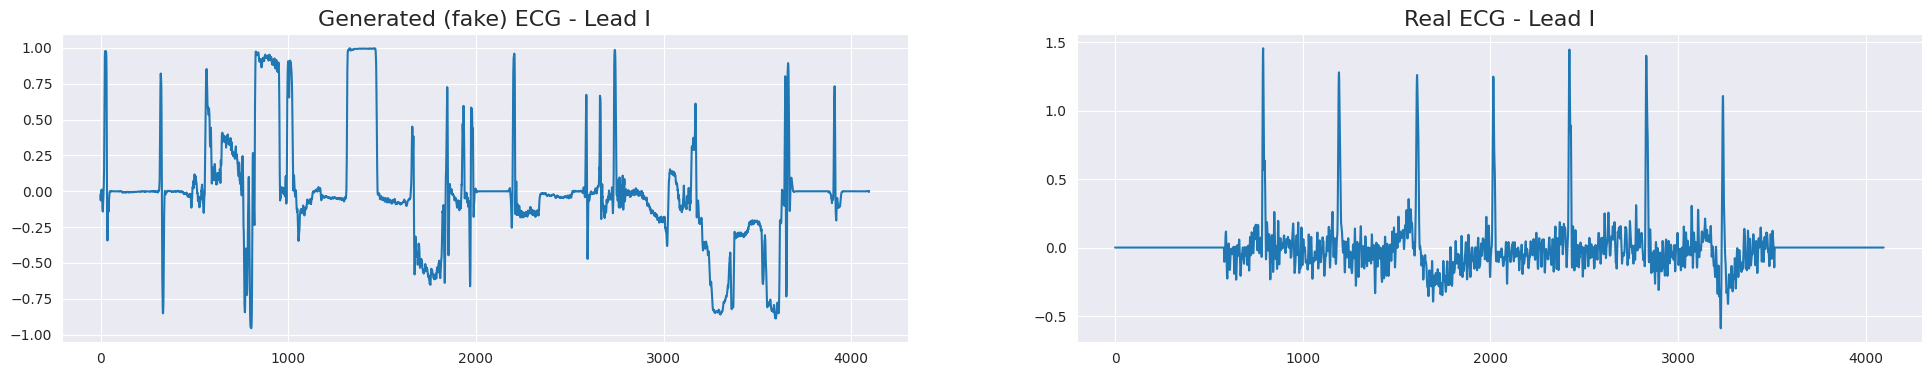

Generator AUROC: 0.0
Generator loss: 0.97222674
Descriminator AUROC: 0.40234375
Descriminator loss: 0.5187727
-------------------
epoch 22
Generator AUROC: 0.0
Generator loss: 0.97217196
Descriminator AUROC: 0.60546875
Descriminator loss: 0.5162206
-------------------
epoch 23
Generator AUROC: 0.0
Generator loss: 0.9726586
Descriminator AUROC: 0.32421875
Descriminator loss: 0.5176285
-------------------
epoch 24
Generator AUROC: 0.0
Generator loss: 0.97093767
Descriminator AUROC: 0.62890625
Descriminator loss: 0.5179549
-------------------
epoch 25
Generator AUROC: 0.0
Generator loss: 0.97417927
Descriminator AUROC: 0.34765625
Descriminator loss: 0.5180247
-------------------
epoch 26


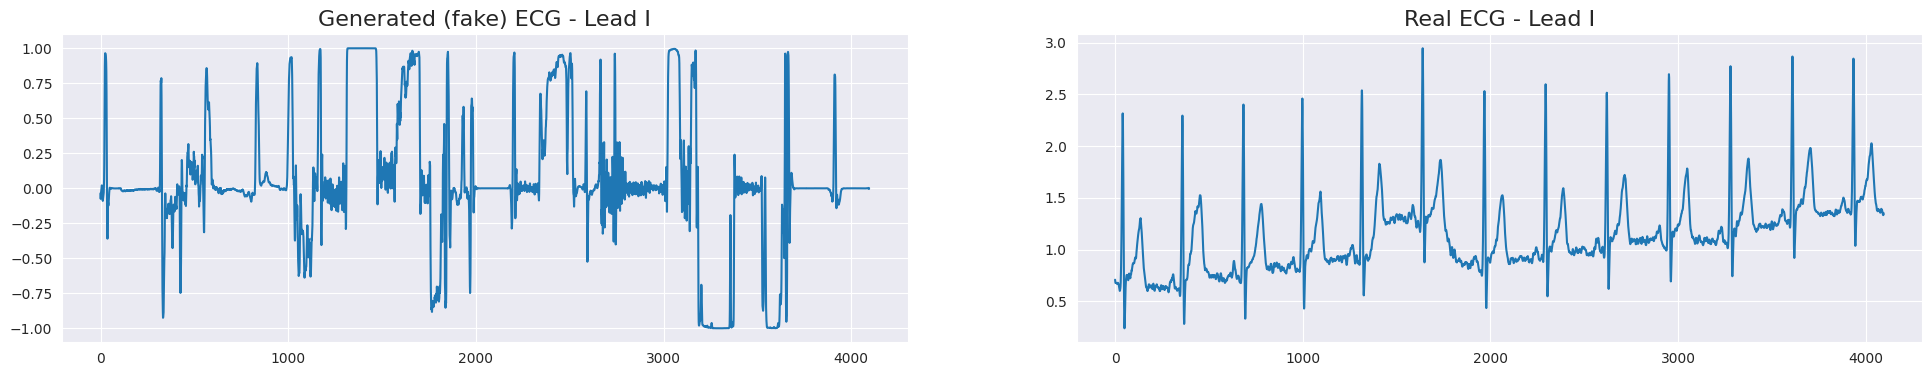

Generator AUROC: 0.0
Generator loss: 0.9731424
Descriminator AUROC: 0.359375
Descriminator loss: 0.51591456
-------------------
epoch 27
Generator AUROC: 0.0
Generator loss: 0.96944404
Descriminator AUROC: 0.41796875
Descriminator loss: 0.52212805
-------------------
epoch 28
Generator AUROC: 0.0
Generator loss: 0.96767354
Descriminator AUROC: 0.4921875
Descriminator loss: 0.5186608
-------------------
epoch 29
Generator AUROC: 0.0
Generator loss: 0.9679723
Descriminator AUROC: 0.427734375
Descriminator loss: 0.5159117
-------------------
epoch 30
Generator AUROC: 0.0
Generator loss: 0.9684601
Descriminator AUROC: 0.421875
Descriminator loss: 0.51738787
-------------------
epoch 31


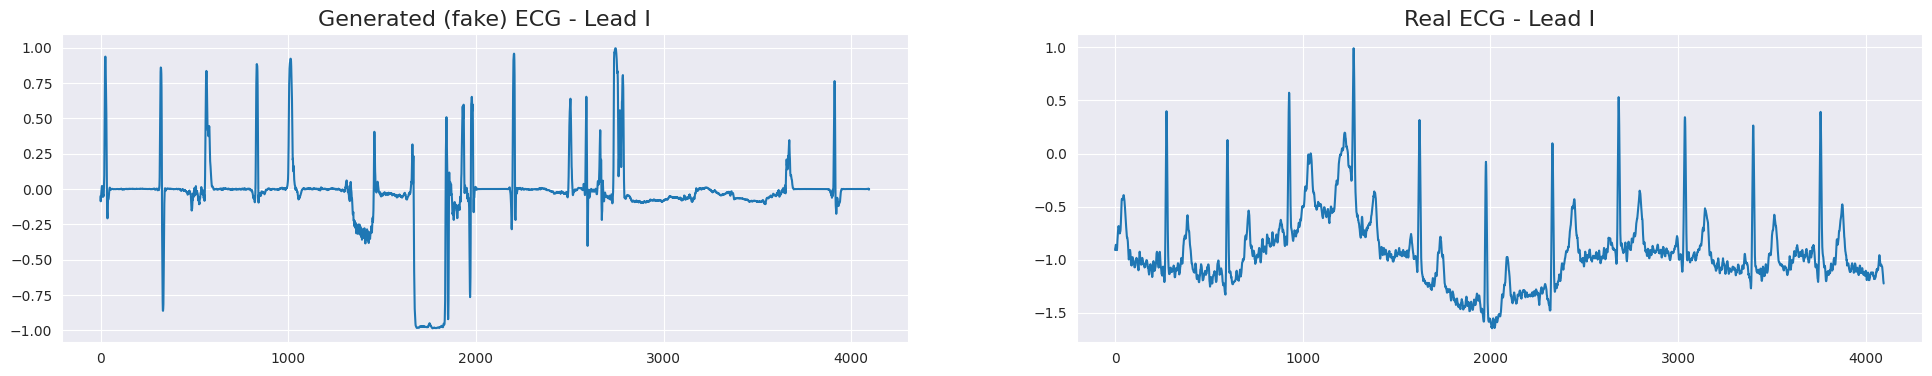

Generator AUROC: 0.0
Generator loss: 0.96875125
Descriminator AUROC: 0.46875
Descriminator loss: 0.5200916
-------------------
epoch 32
Generator AUROC: 0.0
Generator loss: 0.96813464
Descriminator AUROC: 0.48046875
Descriminator loss: 0.51624054
-------------------
epoch 33
Generator AUROC: 0.0
Generator loss: 0.9663369
Descriminator AUROC: 0.41796875
Descriminator loss: 0.5157291
-------------------
epoch 34
Generator AUROC: 0.0
Generator loss: 0.9669463
Descriminator AUROC: 0.6171875
Descriminator loss: 0.51786035
-------------------
epoch 35
Generator AUROC: 0.0
Generator loss: 0.9667707
Descriminator AUROC: 0.41796875
Descriminator loss: 0.52120095
-------------------
epoch 36


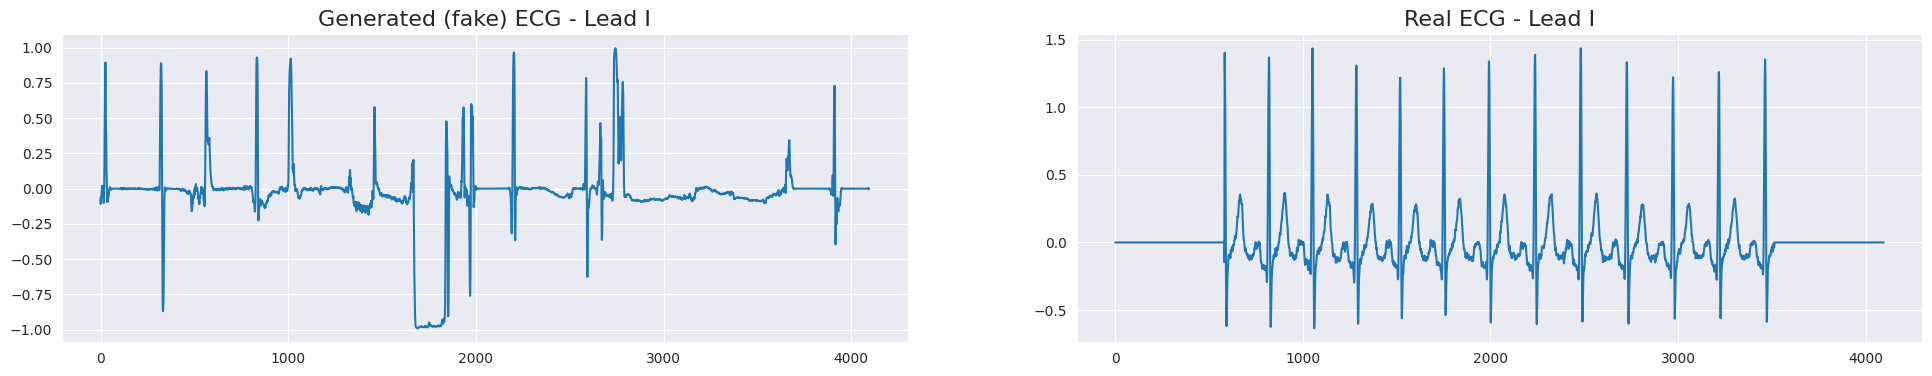

Generator AUROC: 0.0
Generator loss: 0.96681815
Descriminator AUROC: 0.625
Descriminator loss: 0.5171614
-------------------
epoch 37
Generator AUROC: 0.0
Generator loss: 0.9667404
Descriminator AUROC: 0.5546875
Descriminator loss: 0.520902
-------------------
epoch 38
Generator AUROC: 0.0
Generator loss: 0.96554804
Descriminator AUROC: 0.53125
Descriminator loss: 0.517519
-------------------
epoch 39
Generator AUROC: 0.0
Generator loss: 0.96528625
Descriminator AUROC: 0.73828125
Descriminator loss: 0.5161893
-------------------
epoch 40
Generator AUROC: 0.0
Generator loss: 0.9654685
Descriminator AUROC: 0.4140625
Descriminator loss: 0.51898086
-------------------
epoch 41


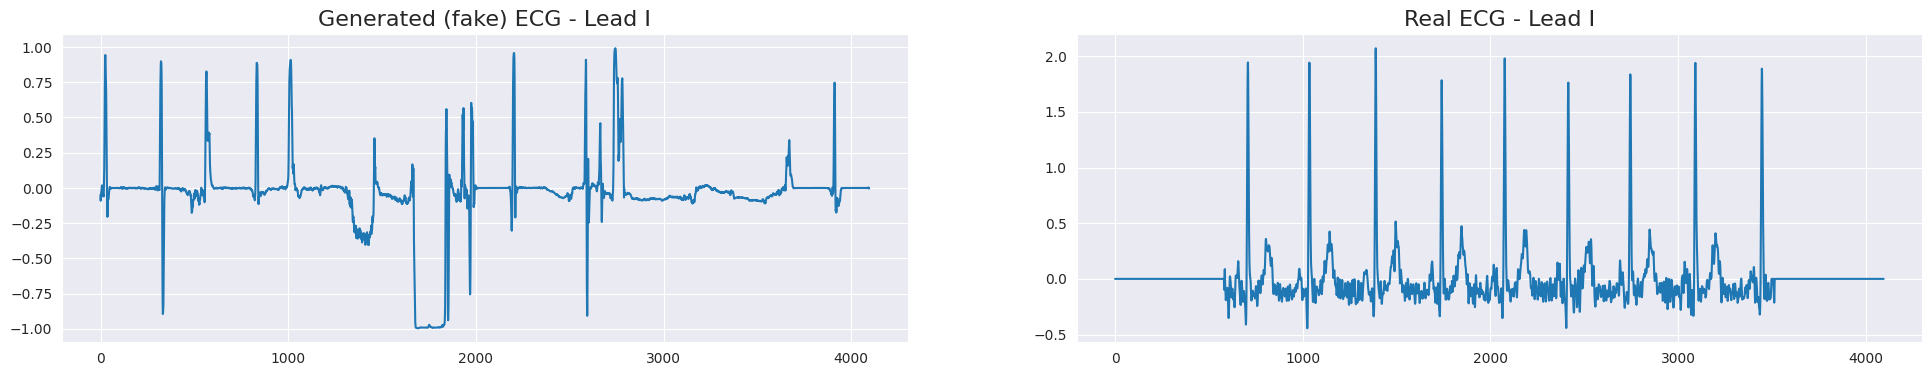

Generator AUROC: 0.0
Generator loss: 0.96533674
Descriminator AUROC: 0.578125
Descriminator loss: 0.52039653
-------------------
epoch 42
Generator AUROC: 0.0
Generator loss: 0.96533966
Descriminator AUROC: 0.52734375
Descriminator loss: 0.5169913
-------------------
epoch 43
Generator AUROC: 0.0
Generator loss: 0.96544534
Descriminator AUROC: 0.48828125
Descriminator loss: 0.5202474
-------------------
epoch 44
Generator AUROC: 0.0
Generator loss: 0.96515334
Descriminator AUROC: 0.4921875
Descriminator loss: 0.51914334
-------------------
epoch 45
Generator AUROC: 0.0
Generator loss: 0.9651541
Descriminator AUROC: 0.5546875
Descriminator loss: 0.5196817
-------------------
epoch 46


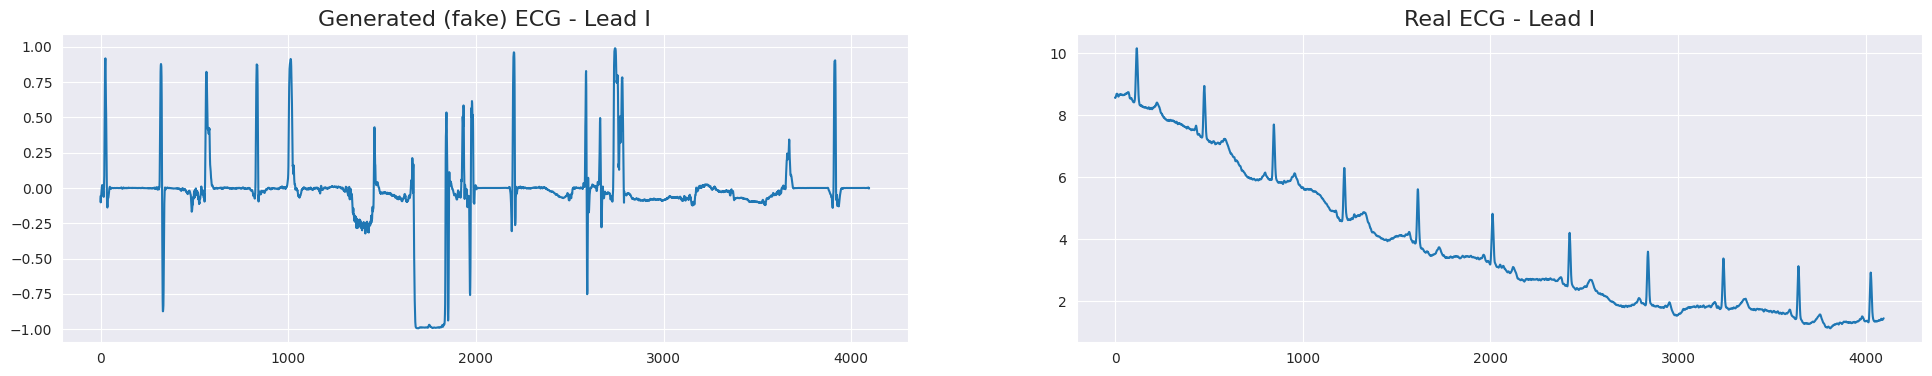

Generator AUROC: 0.0
Generator loss: 0.9648918
Descriminator AUROC: 0.48828125
Descriminator loss: 0.51960564
-------------------
epoch 47
Generator AUROC: 0.0
Generator loss: 0.9649667
Descriminator AUROC: 0.6328125
Descriminator loss: 0.5217809
-------------------
epoch 48
Generator AUROC: 0.0
Generator loss: 0.9647498
Descriminator AUROC: 0.52734375
Descriminator loss: 0.51701015
-------------------
epoch 49
Generator AUROC: 0.0
Generator loss: 0.9646919
Descriminator AUROC: 0.5234375
Descriminator loss: 0.51980966
-------------------
epoch 50
Generator AUROC: 0.0
Generator loss: 0.96447146
Descriminator AUROC: 0.546875
Descriminator loss: 0.52208936
-------------------
epoch 51


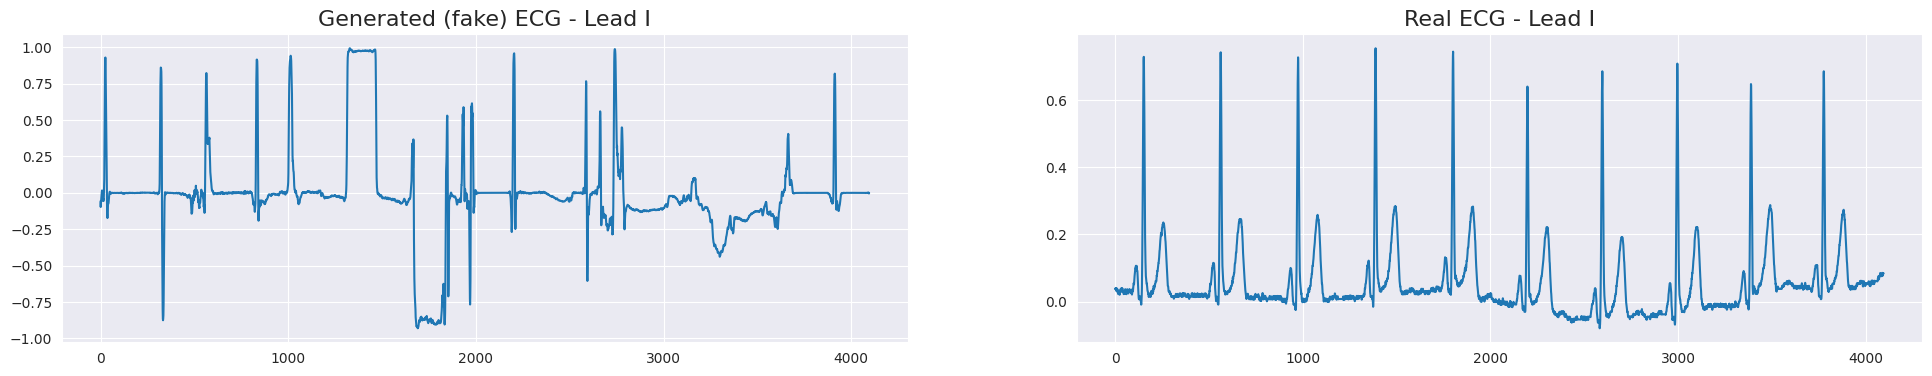

Generator AUROC: 0.0
Generator loss: 0.96426445
Descriminator AUROC: 0.41796875
Descriminator loss: 0.5205434
-------------------
epoch 52
Generator AUROC: 0.0
Generator loss: 0.96438164
Descriminator AUROC: 0.44921875
Descriminator loss: 0.5230103
-------------------
epoch 53
Generator AUROC: 0.0
Generator loss: 0.964592
Descriminator AUROC: 0.287109375
Descriminator loss: 0.51949084
-------------------
epoch 54
Generator AUROC: 0.0
Generator loss: 0.9643579
Descriminator AUROC: 0.4140625
Descriminator loss: 0.5181157
-------------------
epoch 55
Generator AUROC: 0.0
Generator loss: 0.9644777
Descriminator AUROC: 0.5546875
Descriminator loss: 0.51902926
-------------------
epoch 56


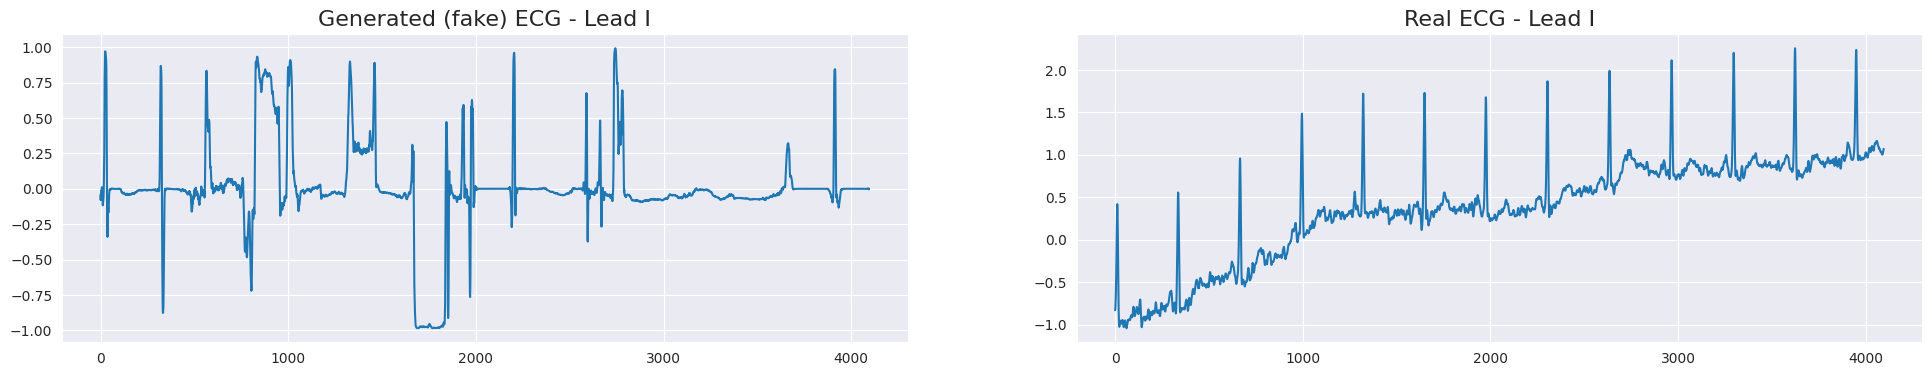

Generator AUROC: 0.0
Generator loss: 0.9643359
Descriminator AUROC: 0.51953125
Descriminator loss: 0.5196009
-------------------
epoch 57
Generator AUROC: 0.0
Generator loss: 0.9645127
Descriminator AUROC: 0.40625
Descriminator loss: 0.52352905
-------------------
epoch 58
Generator AUROC: 0.0
Generator loss: 0.9643521
Descriminator AUROC: 0.25390625
Descriminator loss: 0.52050245
-------------------
epoch 59
Generator AUROC: 0.0
Generator loss: 0.964295
Descriminator AUROC: 0.5546875
Descriminator loss: 0.515365
-------------------
epoch 60


In [ ]:
batch_size=32
latent_dim=12
steps = len(ECGs)//32
half_batch = batch_size // 2
epochs = 100
#gen = generator()
#desc = discriminator()
init_lr_desc = 0.0001
init_lr_gen = 0.0004
opt_desc = tf.keras.optimizers.Adam(learning_rate=init_lr_desc,beta_1=0.5, beta_2=0.9)
opt_gen = tf.keras.optimizers.Adam(learning_rate=init_lr_gen,beta_1=0.5, beta_2=0.9)
print("Before training:")
res = gen(generate_latent_points(12,1))
compare_real_and_gen_ecg(res)
print("-------------------")
for epoch in range(epochs):
    if epoch % 5 == True:
        init_lr_desc = init_lr_desc/2
        init_lr_gen = init_lr_gen/2
        opt_desc.lr = init_lr_desc
        opt_gen.lr = init_lr_gen
    accu_loss_gan = []
    accu_loss_desc = []
    print("epoch {}".format(epoch))
    for step in range(steps):
        x_real, y_real = generate_real_samples(ECGs,half_batch)
        x_fake, y_fake = generate_fake_samples(latent_dim,gen,half_batch)
        X_train = np.vstack([x_real,x_fake])
        y_train = np.vstack([y_real,y_fake])
        p = np.random.permutation(len(y_train)) #shuffle

        #Training Discriminator
        with tf.GradientTape() as tape:
            pred_desc = desc(X_train[p])
            loss_desc = tf.keras.losses.binary_crossentropy(y_train[p], pred_desc)
        accu_loss_desc.append(loss_desc)
        grads = tape.gradient(loss_desc, desc.trainable_variables)
        opt_desc.apply_gradients(zip(grads, desc.trainable_variables))
        
        #Training Generator
        with tf.GradientTape() as tape:
            x_latent = generate_latent_points(latent_dim,batch_size)
            x_gan = gen(x_latent)
            y_gan = np.ones((batch_size, 1))
            pred_gan = desc(x_gan)
            loss_gan = tf.keras.losses.binary_crossentropy(y_gan, pred_gan)
        accu_loss_gan.append(loss_gan)
        grads = tape.gradient(loss_gan, gen.trainable_variables)
        opt_gen.apply_gradients(zip(grads, gen.trainable_variables))
        #summarize_performance(1,gen, desc, latent_dim, ECGs)
    if epoch % 5 == True:
        res = gen(generate_latent_points(12,1))
        compare_real_and_gen_ecg(res)
    print("Generator AUROC:", roc_auc_score(np.concatenate([y_gan.ravel(),np.array([0])]),np.concatenate([np.asarray(pred_gan).ravel(),np.array([0.5])])))
    print("Generator loss:", np.mean(np.asarray(accu_loss_gan)))
    print("Descriminator AUROC:", roc_auc_score(y_train.ravel(),np.asarray(pred_desc).ravel()))   
    print("Descriminator loss:", np.mean(np.asarray(accu_loss_desc)))
    print("-------------------")

In [ ]:
gen.save_weights("generator_weights_round2.h5")
desc.save_weights("discriminator_weights_round2.h5")

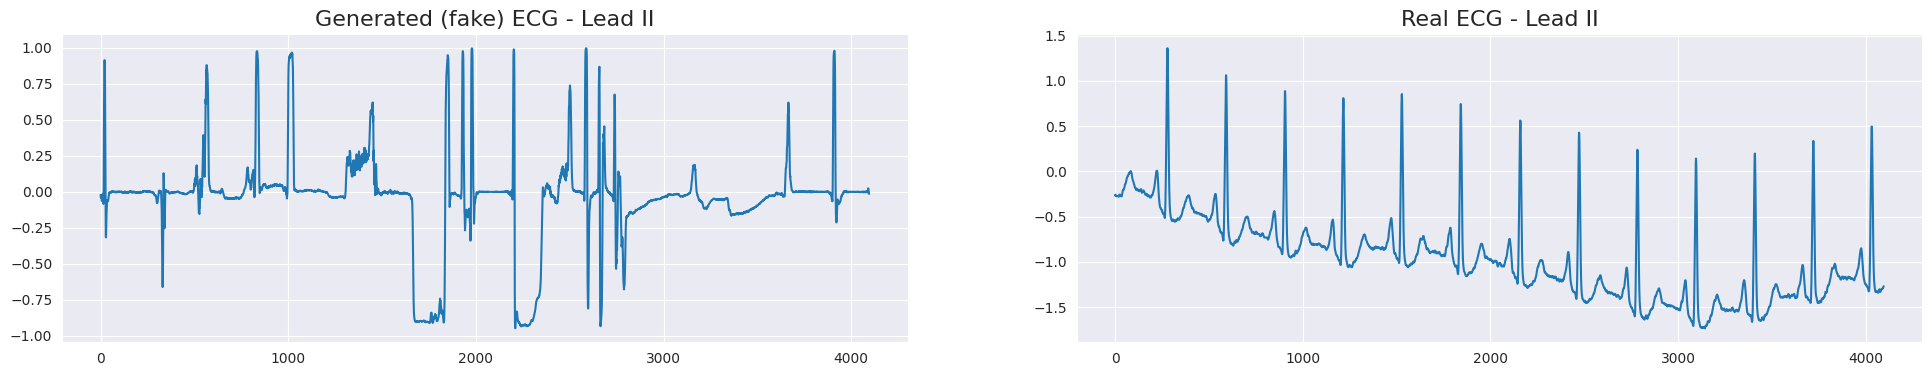

In [17]:
# Generating Test Samples
def test_real_and_gen_ecg(generated_ecg):
    """Plot real and generated ECGs side by side"""
    plt.figure(figsize=(24,4))
    plt.subplot(1,2,1)
    plt.title("Generated (fake) ECG - Lead II", fontsize=16)
    plt.plot(generated_ecg[0,:,1])
    plt.subplot(1,2,2)
    plt.title("Real ECG - Lead II", fontsize=16)
    # rand_idx = np.random.choice(np.arange(len(ECGs)))
    rand_idx = 0
    plt.plot(ECGs[rand_idx,:,1])
    plt.show()

res = gen(generate_latent_points(12,1))
test_real_and_gen_ecg(res)